In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        # transforms.Normalize(mean, std),
        # lambda x: torch.flip(x, [1]),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)
trainset = torchvision.datasets.ImageFolder(
    root="./data/caltech101/train",
    transform=transform,
)

valset = torchvision.datasets.ImageFolder(
    root="./data/caltech101/val",
    transform=transform,
)

testset = torchvision.datasets.ImageFolder(
    root="./data/caltech101/test",
    transform=transform,
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=False, num_workers=2
)

valloader = torch.utils.data.DataLoader(
    valset, batch_size=128, shuffle=False, num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2
)

In [2]:
from cbir import *
from cbir.featuring.vgg16 import VGG16Extractor
from cbir.pipeline import *

rgb_histogram = RGBHistogram(n_bin=8, h_type="region")
resnet = ResNetExtractor(model = "resnet18", device="cuda")
siftbow = SIFTBOWExtractor(mode="tfidf")
# vgg16 = VGG16Extractor(device="cuda")
array_store = NPArrayStore(retrieve=KNNRetrieval(metric="cosine"))

In [3]:
from tqdm import tqdm
import numpy as np
train_img = []
for images, labels in tqdm(valloader):
    images = (images.numpy().transpose(0,2,3,1) * 255).astype(np.uint8)
    train_img.append(images)
    
train_img = np.concatenate(train_img)
siftbow.fit(train_img, k=64)

  0%|          | 0/11 [00:00<?, ?it/s]/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

Fit Kmeans clustering to create BOW
Fit IDF for TF-IDF Transformation
Complete Fitting SIFT BOW Extractor


In [4]:
cbir = CBIR(siftbow, array_store)

In [5]:
for images, labels in tqdm(trainloader):
    images = (images.numpy().transpose(0,2,3,1) * 255).astype(np.uint8)
    cbir.indexing(images)

  0%|          | 0/50 [00:00<?, ?it/s]/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

In [7]:
cbir.feature_extractor.mode = "tfidf"

In [22]:
img = cv2.imread("/home/edtechai/works/vunt/CV-basic/data/caltech101/test/ant/image_0024.jpg")
img = transform(img)
img = (img.numpy().transpose(1,2,0) * 255).astype(np.uint8)

/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [23]:
# rs = cbir.retrieve(np.expand_dims(img, axis=0), k=5)
rs = cbir.retrieve(img, k=10)

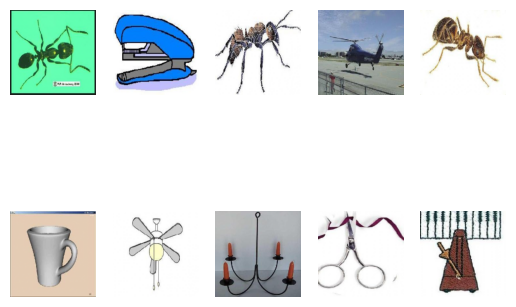

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,5)
for i, r in enumerate(rs):
    # ax[i].imshow(r.image.transpose((1, 2, 0)))
    ax[i // 5][i % 5].imshow(r.image)
    # ax[i].set_title(f"{r.distance}")
    ax[i // 5][i % 5].axis("off")
plt.show()

In [25]:
for images, labels in tqdm(trainloader):
    images = images.numpy().transpose(0,2,3,1)
    cbir.indexing(images)

  0%|          | 0/50 [00:00<?, ?it/s]/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

error: OpenCV(4.10.0) /io/opencv/modules/features2d/src/sift.dispatch.cpp:512: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'detectAndCompute'


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# you are allowed to import other Python packages above
##########################
def computeFeatures(img):
    # Inputs
    # img: 3-D numpy array of an RGB color image
    #
    # Output
    # featvect: A D-dimensional vector of the input image 'img'
    #
    #########################################################################
    # ADD YOUR CODE BELOW THIS LINE
    
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kps, des = sift.detectAndCompute(img, None)

    featvect = des
    
    
    # END OF YOUR CODE
    #########################################################################
    return featvect 

In [ ]:
from __future__ import annotations

from os import PathLike
from typing import Literal

from numpy import ndarray
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer
from tqdm import tqdm

from cbir.feature_extractor import SingleFeatureExtractor


class SIFTBOWExtractor(SingleFeatureExtractor):
    def __init__(self, mode : Literal["bow", "tfidf"] = "tfidf") -> None:
        super().__init__()
        self.feat = []
        self.mode = mode
    
    def __call__(self, input: ndarray | PathLike):
        img = super().read_image(input)  
        # Return vector if mode is bow
        if self.mode == "bow":
            bow_hist = self.__bow(img)
            return bow_hist / max(bow_hist)
        elif self.mode == "tfidf":
            tfidf = self.__tfidf(img)
            return tfidf
        
    
    def fit(self, images: list, k=200):
        for img in tqdm(images, desc="Extracting Features"):
            feature = self.__computeFeatures(img)
            if feature is not None:
                self.feat.append(feature)
            
        # Stack all features together
        alldes = np.vstack(self.feat)
        
        print("Fit Kmeans clustering to create BOW")
        # Perform Kmeans clustering and get the cluster centers to reduce dimensionality
        alldes = np.float32(alldes) 
        self.kmeans = KMeans(n_clusters=200, random_state=0).fit(alldes)  
        codebook, distortion = self.kmeans.cluster_centers_, self.kmeans.inertia_
        
        print("Fit IDF for TF-IDF Transformation")
        # Fit IDF Transformation for TF-IDF 
        # Create Bag-of-word list
        bow = []

        # Get label for each image, and put into a histogram (BoW)
        for f in self.feat:
            code = self.kmeans.predict(f)
            bow_hist, _ = np.histogram(code, self.kmeans.n_clusters)
            bow.append(bow_hist)
            
        self.tfidf_transformer = TfidfTransformer(smooth_idf=True)
        self.tfidf_transformer.fit(bow)
        
        print("Complete Fitting SIFT BOW Extractor")
    
    def __bow(self, img: np.ndarray):
        feature = self.__computeFeatures(img)
        # Get label for each image, and put into a histogram (BoW)
        try:
            code = self.kmeans.predict(feature)
        except:
            raise Exception("Must call fit() to create codebook before feature extraction")
        bow_hist, _ = np.histogram(code, self.kmeans.n_clusters)
        
        return bow_hist
    
    def __tfidf(self, img: np.ndarray):
        bow_hist = self.__bow(img)
        return self.tfidf_transformer.transform([bow_hist]).toarray()[0]
    
    def clean(self):
        self.feat = []

    def __computeFeatures(self, img):
        sift = cv2.SIFT_create()
        kps, des = sift.detectAndCompute(img, None)
        return des

In [ ]:
from tqdm import tqdm
import numpy as np
train_img = []
for images, labels in tqdm(valloader):
    images = (images.numpy().transpose(0,2,3,1) * 255).astype(np.uint8)
    train_img.append(images)
    # cbir.indexing(images)

  0%|          | 0/11 [00:00<?, ?it/s]/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

In [ ]:
train_img = np.concatenate(train_img)

In [ ]:
train_img.shape

(1326, 224, 224, 3)

In [ ]:
siftbow = SIFTBOWExtractor(mode="tfidf")

In [ ]:
siftbow.fit(train_img)

Extracting Features: 100%|██████████| 1326/1326 [00:09<00:00, 141.63it/s]


Fit Kmeans clustering to create BOW
Fit IDF for TF-IDF Transformation
Complete Fitting SIFT BOW Extractor


In [ ]:
siftbow('/home/edtechai/works/vunt/CV-basic/data/caltech-101/sunflower/image_0003.jpg')

array([0.05117472, 0.05063851, 0.02340547, 0.04912742, 0.        ,
       0.05080596, 0.        , 0.        , 0.11221405, 0.        ,
       0.27064078, 0.04920741, 0.02446413, 0.11900985, 0.02420791,
       0.        , 0.02515304, 0.09881644, 0.04869079, 0.02494751,
       0.07453702, 0.0515269 , 0.        , 0.02563535, 0.02289074,
       0.        , 0.02355543, 0.05265987, 0.        , 0.04825967,
       0.0263521 , 0.048968  , 0.0969883 , 0.05030607, 0.        ,
       0.0477571 , 0.        , 0.02664294, 0.04688567, 0.10003564,
       0.04798814, 0.02378288, 0.04481737, 0.09475096, 0.        ,
       0.04783394, 0.07399163, 0.02434539, 0.02468398, 0.05047189,
       0.02478486, 0.        , 0.12352055, 0.048968  , 0.12924694,
       0.07429391, 0.07527336, 0.02550821, 0.04985419, 0.16080972,
       0.07521159, 0.06999293, 0.0672789 , 0.14201265, 0.        ,
       0.04928759, 0.20576517, 0.04837671, 0.09339828, 0.05131327,
       0.        , 0.06993722, 0.04912742, 0.        , 0.09849

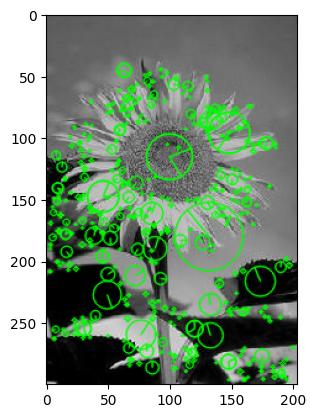

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Create a SIFT feature detector and descriptor extractor
sift = cv2.SIFT_create()

# Load an image
img = cv2.imread('/home/edtechai/works/vunt/CV-basic/data/caltech-101/sunflower/image_0003.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

# Detect keypoints and compute descriptors
kps, des = sift.detectAndCompute(img, None)

# Draw keypoints on the image
img_kps = cv2.drawKeypoints(img, kps, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

# Display the image with keypoints
plt.imshow(img_kps)

# # Print the number of keypoints detected
# print(f'Number of keypoints: {len(kps)}')

# # Print the shape of the descriptors
# print(f'Descriptor shape: {des.shape}')

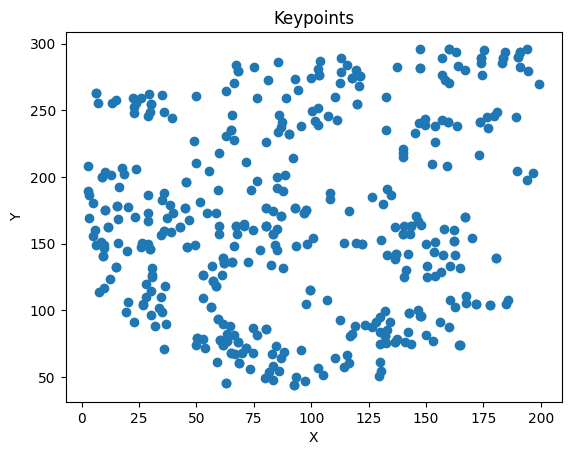

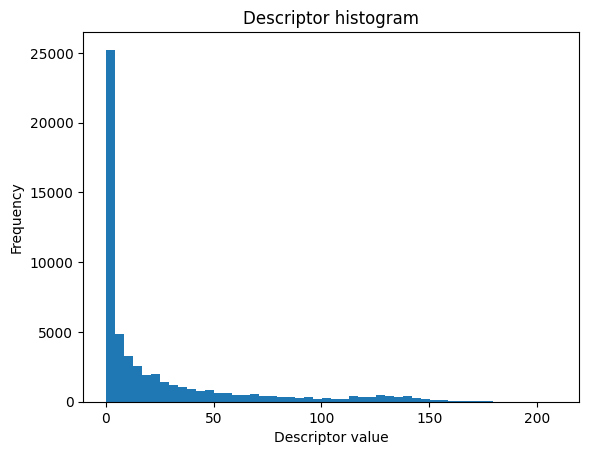

In [ ]:
import matplotlib.pyplot as plt

# Plot keypoints as scatter points
plt.scatter([kp.pt[0] for kp in kps], [kp.pt[1] for kp in kps])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Keypoints')
plt.show()

# Plot descriptors as histograms
plt.hist(des.flatten(), bins=50)
plt.xlabel('Descriptor value')
plt.ylabel('Frequency')
plt.title('Descriptor histogram')
plt.show()

In [ ]:
import pickle
a = pickle.load(open("/home/edtechai/works/vunt/CV-basic/CBIR_System_using_SIFT/bow.pkl", "rb"))